In [1]:
import jax.random as jr 
import jax.numpy as jnp
import dill
import os
import gymnax
import equinox as eqx
import matplotlib.pyplot as plt

from reinforce import visualize_trajectory, rollout_parallel

checkpoints = []
for i in range(0, 5):
    with open(f'../checkpoints/17:14:38/{i}.pkl', 'rb') as file:
        checkpoints.append(dill.load(file))

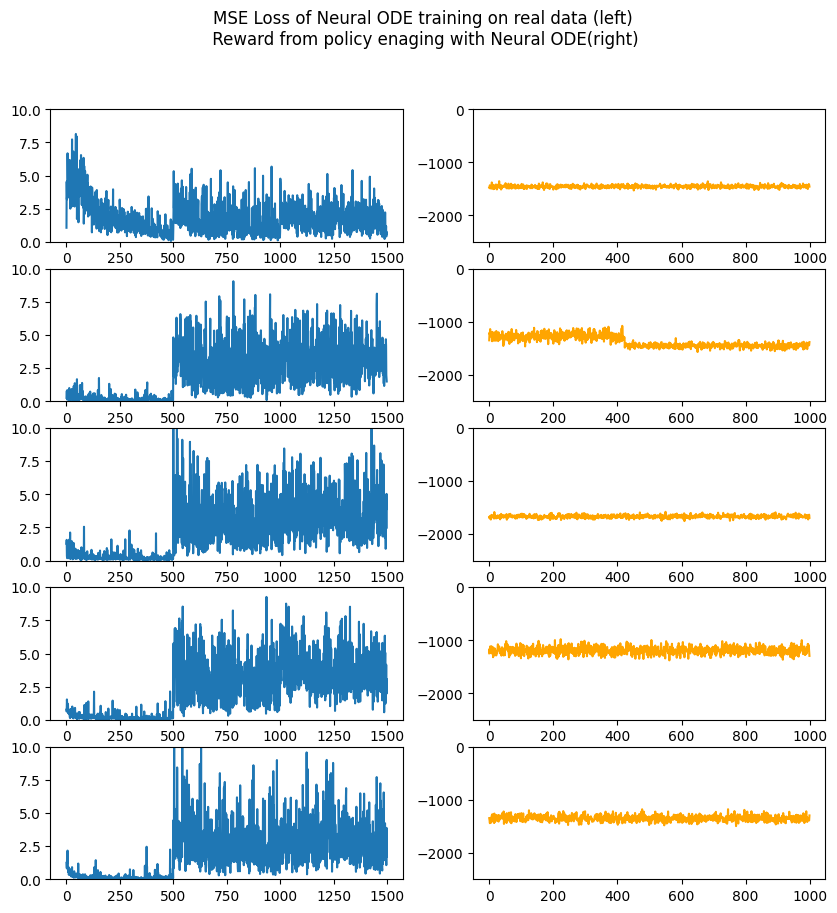

In [2]:
checkpoints[0].keys()

dynamics_losses = [checkpoint['dynamics_losses'] for checkpoint in checkpoints]
policy_losses = [checkpoint['policy_losses'] for checkpoint in checkpoints]
dynamicss = [checkpoint['dynamics'] for checkpoint in checkpoints]
policies = [checkpoint['policy'] for checkpoint in checkpoints]


loss_fig, loss_axes = plt.subplots(5, 2, figsize=(10, 10))

loss_fig.suptitle('MSE Loss of Neural ODE training on real data (left) \n Reward from policy enaging with Neural ODE(right) ')
for ax, dyn_loss, pol_loss in zip(loss_axes, dynamics_losses, policy_losses):
    ax[0].plot(dyn_loss)
    ax[0].set_ylim(0, 10)

    ax[1].plot(pol_loss, color='orange')
    ax[1].set_ylim(-2500, 0)

As can be seen training the policy on the Neural ODE was not succesfull. Instead we train both models in isolation and test Model Predictive Control that way.

In [3]:
with open("../checkpoints/isolated_training/new_policy.pkl", "rb") as file:
    policy = dill.load(file)
with open("../checkpoints/isolated_training/new_dynamics.pkl", "rb") as file:
    dynamics = dill.load(file)

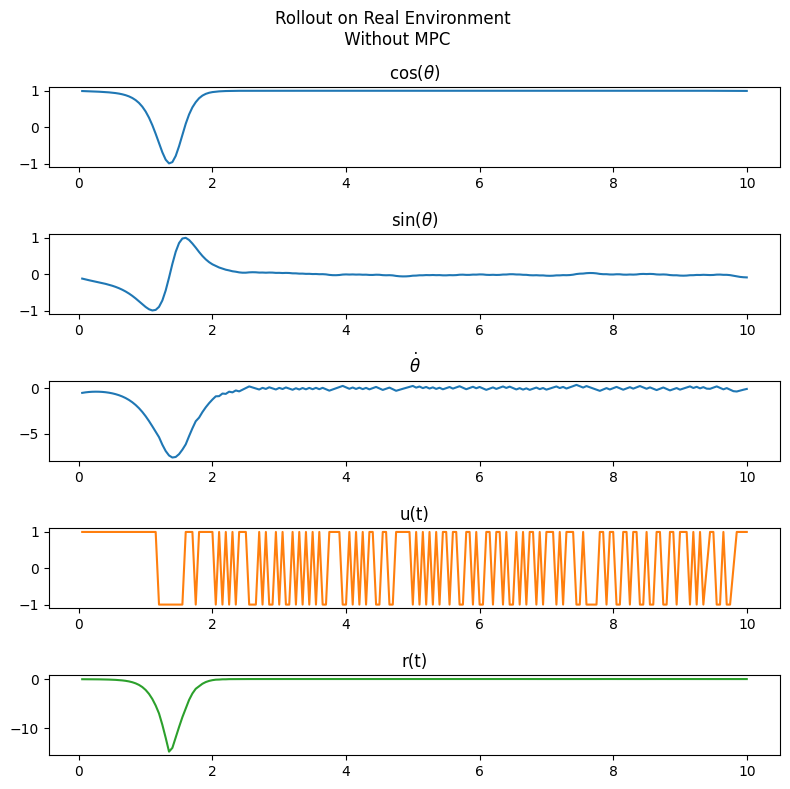

TypeError: 'NoneType' object cannot be interpreted as an integer

In [4]:
SEED = 0 
key = jr.PRNGKey(SEED)
key_vis = key

# Init Environment
env, env_params = gymnax.make("Pendulum-v1")

# Visualize stand alone policy on real environment
visualize_trajectory(policy, env, env_params, key=key_vis, title="Rollout on Real Environment \n Without MPC")
visualize_trajectory(policy, eqx.partition(dynamics, eqx.is_inexact_array), env_params, key=key_vis, title="Rollout on Neural ODE \n Without MPC")

In [ ]:
# import jax
# from functools import partial as pt

# def get_init_obs(key):
#     high = jnp.array([jnp.pi, 1])
#     init_state = jr.uniform(key, shape=(2,), minval=-high, maxval=high)
#     init_obs = jnp.array([
#         jnp.cos(init_state[0]),
#         jnp.sin(init_state[0]),
#         init_state[1],
#         ])
#     return init_obs

# def get_action(obs, key, model):
#     ACTIONS = jnp.array([-1, 0, 1])
#     return jr.choice(key, ACTIONS, p=model(obs))

# def get_reward(obs, u):
#     theta = jnp.arctan2(obs[1], obs[0])
#     theta_dot = obs[2]
#     reward = -(
#         angle_normalize(theta) ** 2
#         + 0.1 * theta_dot ** 2
#         + 0.001 * (u ** 2)
#     )
#     reward = reward.squeeze()
#     return reward

# def angle_normalize(x: float) -> float:
#     """Normalize the angle - radians."""
#     return ((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi

# def rollout_ode(key, model, environment_ode, env_params, steps_in_episode):
#     """Rollout a jitted gymnax episode with lax.scan."""

#     def policy_step(carry, vars, env_ode, policy, ts):
#         """lax.scan compatible step transition in jax env."""
#         obs = carry
        
#         key_step, key_net = jr.split(key, 2)
#         action = pt(get_action, model=policy)(obs, key_net)
#         next_obs = env_ode(ts, obs, jnp.expand_dims(action, axis=0))[1, :]
#         reward = get_reward(next_obs, action)
#         carry = next_obs
#         return carry, [obs, action, reward]

#     key_reset, rng_episode = jr.split(key, 2)
#     # Init the environment
#     init_obs = get_init_obs(key_reset)

#     # Scan over episode step loop
#     _, scan_out = jax.lax.scan(
#       pt(policy_step, env_ode=environment_ode, policy=model, ts=jnp.array([0, env_params.dt])),
#       init_obs,
#       (),
#       steps_in_episode
#     )
    
#     obs, action, reward, = scan_out
#     return obs, action, reward


# def rollout_ode_parallel(*args):
#     return eqx.filter_jit(
#         jax.vmap(
#             rollout_ode,
#             in_axes=(0, None, None, None, None)
#         ),
#     )(*args)
    

In [ ]:
plt.plot(obs)
plt.plot(actions)
plt.show()
plt.plot(rewards)

NameError: name 'obs' is not defined

In [ ]:
from functools import partial

def make_rollout_env(environment_params):
    if "gymnax" in str(type(environment_params)):
        env, _ = gymnax.make('Pendulum-v1')

    return env

def rollout(key, model_params, model_static, env_params, steps_in_episode=None):
    """Rollout a jitted gymnax episode with lax.scan."""

    def get_action(obs, key):
      ACTIONS = jnp.array([-1, 0, 1])
      return jr.choice(key, ACTIONS, p=model(obs))

    def policy_step(state_input, tmp, env):
        """lax.scan compatible step transition in jax env."""
        obs, state, rng = state_input
        rng, rng_step, rng_net = jax.random.split(rng, 3)
        action = get_action(obs, rng_net)

        next_obs, next_state, reward, done, _ = env.step(
          rng_step, state, action, env_params
        )

        carry = [next_obs, next_state, rng]
        return carry, [obs, action, reward, state, next_obs, done]

    rng_reset, rng_episode = jax.random.split(key, 2)
    # Init the environment
    env = make_rollout_env(env_params)
    obs, state = env.reset(rng_reset, env_params)
    # Combine model
    model = eqx.combine(model_params, model_static)

    if steps_in_episode is None:
        steps_in_episode = env_params.max_steps_in_episode

    # Scan over episode step loop
    _, scan_out = jax.lax.scan(
      partial(policy_step, env=env),
      [obs, state, rng_episode],
      (),
      steps_in_episode
    )
    
    # Return masked sum of rewards accumulated by agent in episode
    obs, action, reward, state, next_obs, done = scan_out
    return obs, action, reward, state, next_obs, done

In [ ]:
import equinox as eqx
import jax

params, static = eqx.partition(policy, eqx.is_inexact_array)
# rollout(key_rollout, params, static)

env, env_params = gymnax.make('Pendulum-v1')
# visualize_trajectory(policy, env, env_params, key_rollout)
obs, action, reward, state, next_obs, done = rollout(key_rollout, params, static, env_params)